In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import data_utils

print('Path to dataset:', data_utils.butter_data_path())

Path to dataset: s3://oedi-data-lake/butter


# Generate and save PNGs for the star image on the homepage
Default values: mnist, depth 5, rectangle, learning rate 0, label noise 0,

- 2 rows with 5 each
  - **Dataset:** {201 pol, 531 houses, mnist, sleep, wine_quality_white}
  - **Depth:** {3,4,5,6,7}
- 4 rows with 3 each
  - **Learning Rate:** {0.0001, 0.001, 0.01}
  - **Label Noise:** {0, 0.01/2^2, 0.01/2^5}
  - **Regularization Parameter:** {0, 0.0001, 0.01}
  - **Shape:** {rectangle, trapezoid, exponential}

In [2]:
columns = [
    "test_loss_median",
    "experiment_id",
    "size",
    "num_free_parameters",
    'dataset',
    'epochs',
    'shape',
    'depth',
    'learning_rate',
    'kernel_regularizer.l1',
    'label_noise'
]

def get_single_sweep(sweep, filters, columns, grouper):
    df = data_utils.read_pandas(sweep, filters, columns)
    df_expanded = data_utils.extract_data(df, downsample_epochs=True, grouper=grouper)
    return df_expanded

combined_df = pd.DataFrame()

In [3]:
## Dataset (5 slices)

sweep = 'primary_sweep_summary'

filters = [
    ('dataset', 'in', ["201_pol", "537_houses", "mnist", "connect_4", "sleep"]),
    ('shape', '==', 'rectangle'),
    ('depth', '==', 5)
]

title = 'Task'

variable = 'dataset'

df = get_single_sweep(sweep, filters, columns, variable)

df["group"] = title
df["group_variable"] = df[variable]

combined_df = pd.concat([combined_df, df])

In [4]:
## Depth (5 slices)

sweep = 'primary_sweep_summary'

filters = [
    ('dataset', '==', "mnist"),
    ('shape', '==', 'rectangle'),
    ('depth', 'in', [2,3,5,7,9])
]

title = 'Depth'

variable = 'depth'

df = get_single_sweep(sweep, filters, columns, variable)

df["group"] = title
df["group_variable"] = df[variable]

combined_df = pd.concat([combined_df, df])

In [5]:
## L1 Regularization (2 slices)

sweep = 'regularization_sweep_summary'

base_filters = [('dataset', '==', 'mnist'),
    ('shape', '==', 'rectangle'),
    ('depth', '==', 5)]

filters = [
    base_filters + [('kernel_regularizer.l1', '>', 0.009),
    ('kernel_regularizer.l1', '<', 0.011)],
    base_filters + [('kernel_regularizer.l1', '>', 0.159),
    ('kernel_regularizer.l1', '<', 0.161)]
]

title = 'L1 Regularization'

variable = 'kernel_regularizer.l1'

df = get_single_sweep(sweep, filters, columns, variable)

df["group"] = title
df["group_variable"] = df[variable]

combined_df = pd.concat([combined_df, df])


In [6]:
## Label Noise (2 slices)

sweep = 'label_noise_sweep_summary'

base_filters = [
    ('dataset', '==', 'mnist'),
    ('shape', '==', 'rectangle'),
    ('depth', '==', 5)]

filters = [
    base_filters + [('label_noise', '>', 0.09),
    ('label_noise', '<', 0.11)],
    base_filters + [('label_noise', '>', 0.19),
    ('label_noise', '<', 0.21)]
]

title = 'Label Noise'

variable = 'label_noise'

df = get_single_sweep(sweep,filters, columns, variable)

df["group"] = title
df["group_variable"] = df[variable]

combined_df = pd.concat([combined_df, df])


In [7]:
# Shape (2 Slices)

sweep = 'primary_sweep_summary'

filters = [
    ('dataset', '==', "mnist"),
    ('shape', 'in', ['exponential', 'trapezoid']),
    ('depth', '==', 5)
]

title = 'Shape'

variable = 'shape'

df = get_single_sweep(sweep, filters, columns, variable)

df["group"] = title
df["group_variable"] = df[variable]

combined_df = pd.concat([combined_df, df])

In [8]:
# Learning Rate (2 Slices)

sweep = 'learning_rate_sweep_summary'

base_filters = [('dataset', '==', 'mnist'),
    ('shape', '==', 'rectangle'),
    ('depth', '==', 5)]

filters = [
    base_filters + [('learning_rate', '>', 0.009),
    ('learning_rate', '<', 0.011)],
    base_filters + [('learning_rate', '>', 0.0009),
    ('learning_rate', '<', 0.0011)]
]

title = 'Learning Rate'

variable = 'learning_rate'

df = get_single_sweep(sweep, filters, columns, variable)

df["group"] = title
df["group_variable"] = df[variable]

combined_df = pd.concat([combined_df, df])


## Normalize / Transform

In [9]:
combined_df['color'] = combined_df['test_loss_median']

combined_df['color'] = -np.log10(combined_df['color']).astype(float)

mins = combined_df.groupby(["group", "group_variable"])['color'].transform(min)
maxs = combined_df.groupby(["group", "group_variable"])['color'].transform(max)
combined_df['color'] = (combined_df['color']-mins)/(maxs-mins)


## Save each plot as png

Still have some issue with the normalization.

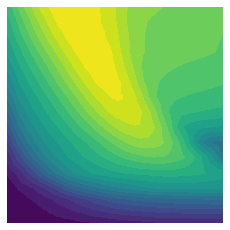

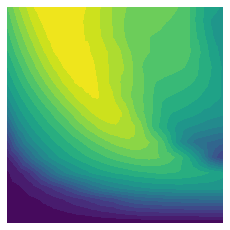

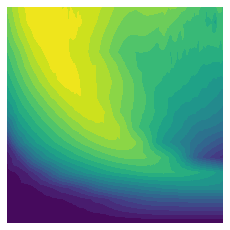

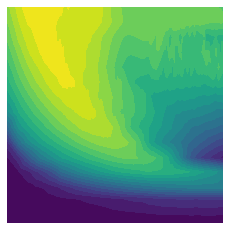

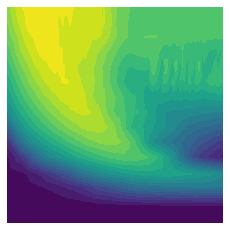

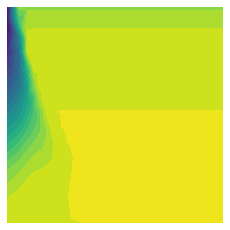

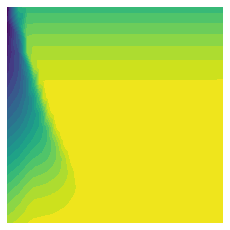

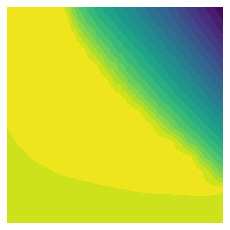

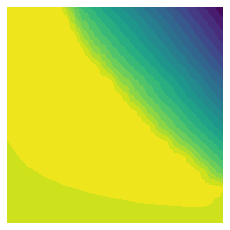

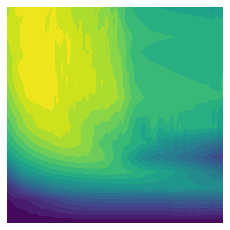

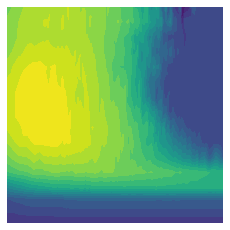

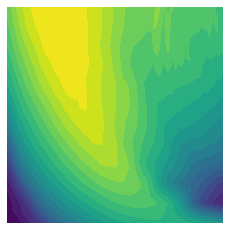

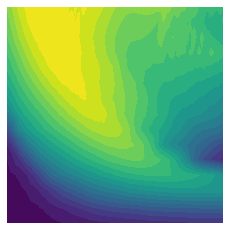

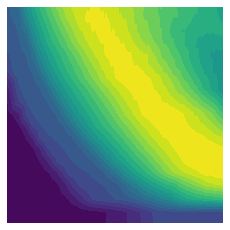

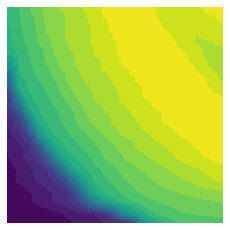

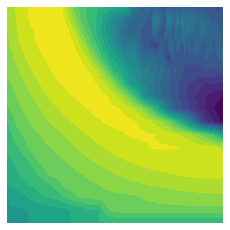

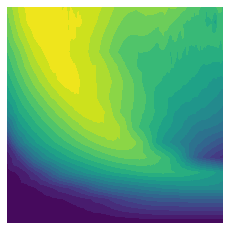

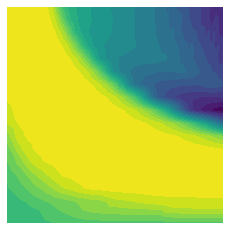

In [10]:
for group_name, gdf in combined_df.groupby("group"):
    for group_value, vdf in gdf.groupby("group_variable"):
        plt.figure(figsize=(3,3))
        plt.tricontourf(
            np.log1p(vdf["epoch"]),
            np.log1p(vdf["num_free_parameters"]),
            vdf["color"],
            vmin=0.0, vmax=1.0,
            levels=20)
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.savefig(f"./star/{group_name}_{group_value}.png")
        plt.show()